In [1]:
import os
import sys
import json
import torch
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from torchsummary import summary
import matplotlib.pyplot as plt
from model_dev.dataloader import data_provider
from model_dev.stock_picker import StockPicker
from visualize_single import Visualize, craete_heatmap
from scatter_plot import Scatter
from model_dev.utills import read_default_args, load_model, get_stock_meta, get_stock_heatmap_matrix

# import mse loss from torch
from torch.nn import MSELoss
# import lregularized mse loss from torch


%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/Users/shiva/Desktop/maestro/model_dev/')
from expirement import ExpMain


## DLinear

In [2]:
default_args = read_default_args()

In [3]:
config_file = '../../configs/config_shiva.json'
config = json.load(open(config_file))
data_dir = config['data_dir']
raw_dir = "{}/{}".format(data_dir, config['raw_data_dir'])
csv_dir = "{}/{}".format(data_dir, config['raw_data_csv'])
ltsf = "{}/ltsf".format(data_dir)

In [43]:
args = {
   'root_path': ltsf,
   'checkpoints': '{}/checkpoints/'.format(data_dir),
   'data_path': '03_23.csv',
   'seq_len': 120,
   'pred_len': 30,
   'batch_size': 1,
   'learning_rate': 0.025,
   'train_only': False,
   'train_epochs': 20,
   'data_segment': None,
   'model': 'nlinear_attention',
   'enc_in': 3,
   'patience': 5,
   'target': 0,
   'stocks': [38, 321, 179]
}

for key, value in args.items():
    default_args[key] = value

args = argparse.Namespace(**default_args)
setting = 'mod_{}_sl{}_pl{}_ds_{}_tg_{}_ch_{}_test'.format(args.model, args.seq_len, args.pred_len, args.data_path.split('.')[0], args.target, args.enc_in)

weights = os.listdir("{}/{}".format(args.checkpoints, setting))
sorted_weights = sorted(weights, key=lambda x: float(x.replace('checkpoint_','').replace('.pth','')), reverse=True)
sorted_weights

['checkpoint_0.0364.pth',
 'checkpoint_0.0243.pth',
 'checkpoint_0.0154.pth',
 'checkpoint_0.0143.pth',
 'checkpoint_0.0126.pth',
 'checkpoint_0.0119.pth']

Load model from /Users/shiva/Desktop/data_maestro//checkpoints/mod_nlinear_attention_sl120_pl30_ds_03_23_tg_0_ch_3_test/checkpoint_0.0119.pth
Original data shape: (14250, 4)
Data shape after inter-day:  8550
val 826


  0%|          | 0/84 [00:00<?, ?it/s]

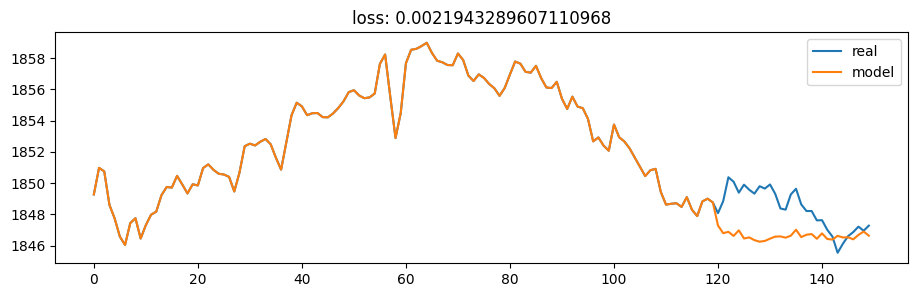

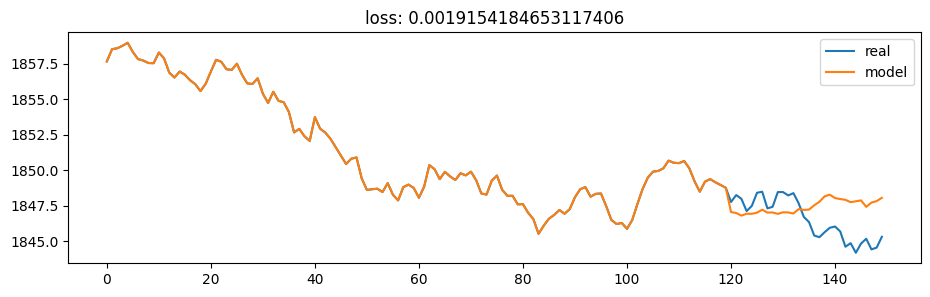

  2%|▏         | 2/84 [00:00<00:07, 11.57it/s]

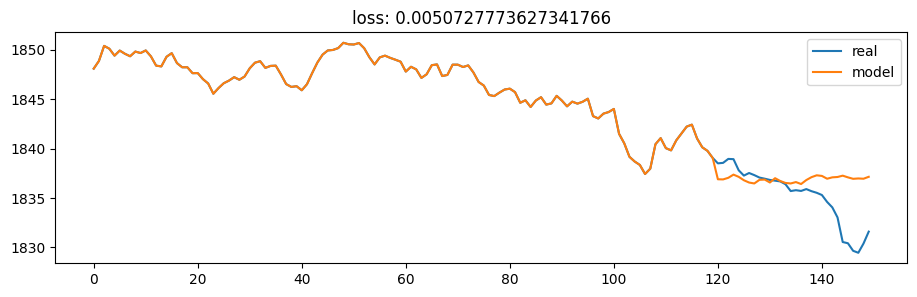

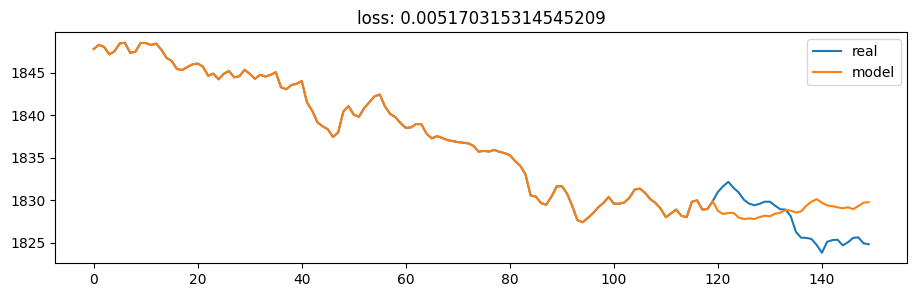

  5%|▍         | 4/84 [00:00<00:06, 12.20it/s]

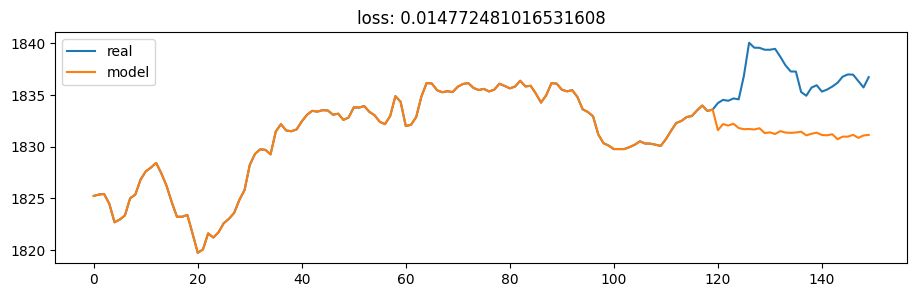

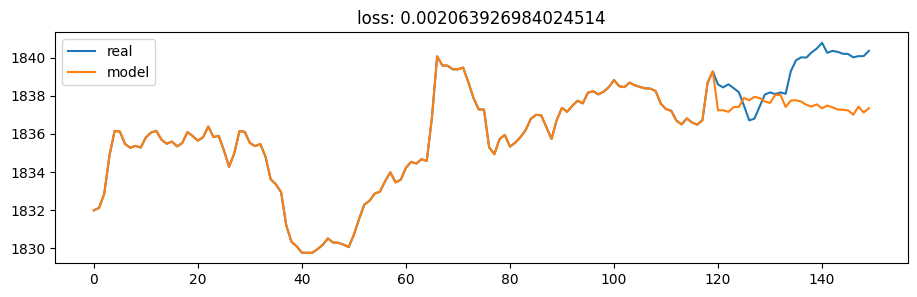

  7%|▋         | 6/84 [00:00<00:07,  9.87it/s]

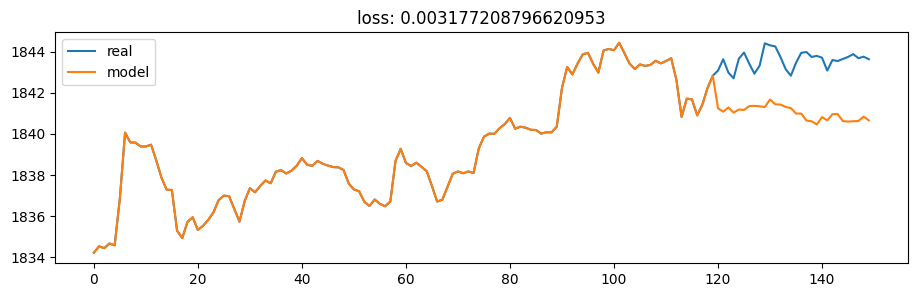

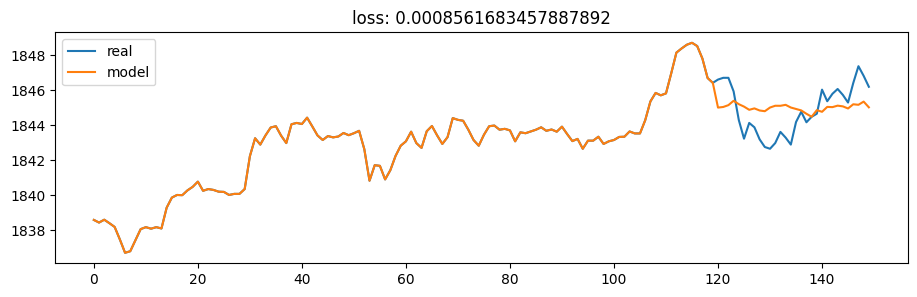

 10%|▉         | 8/84 [00:00<00:07, 10.52it/s]

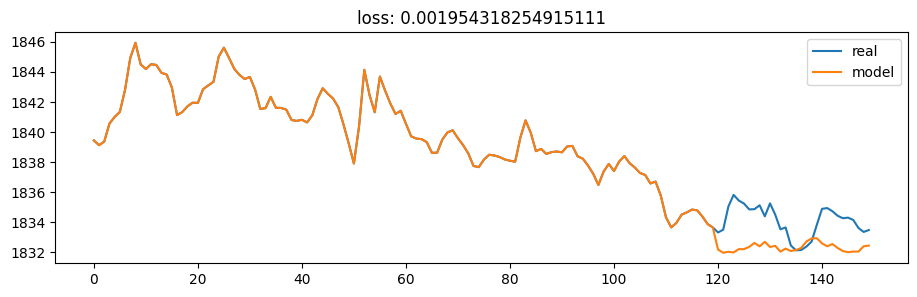

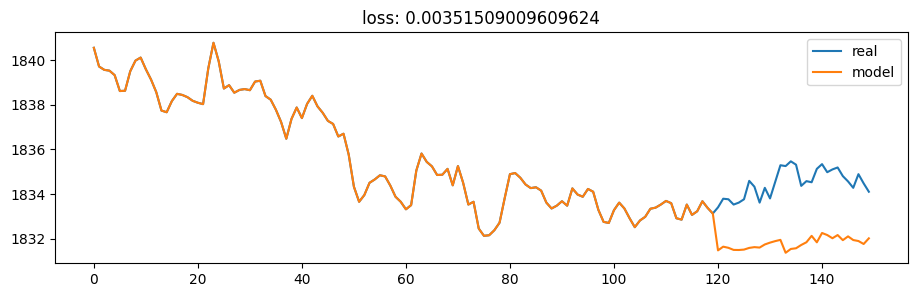

 12%|█▏        | 10/84 [00:00<00:06, 10.94it/s]

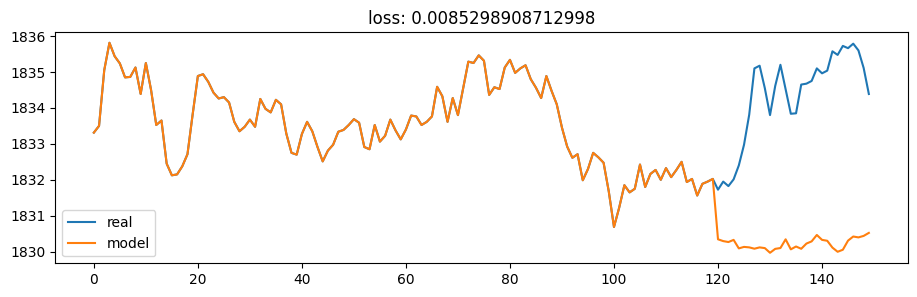

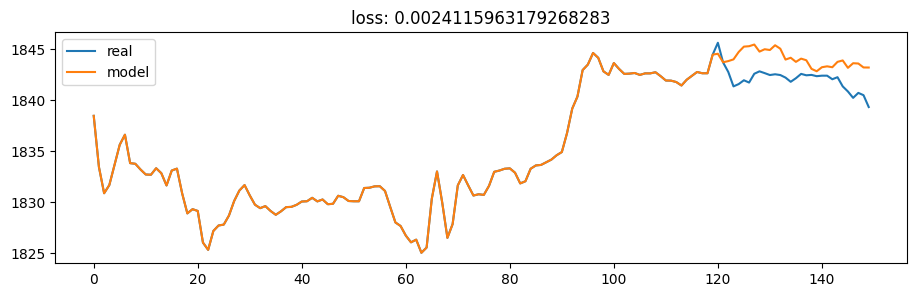

 14%|█▍        | 12/84 [00:01<00:06, 11.24it/s]

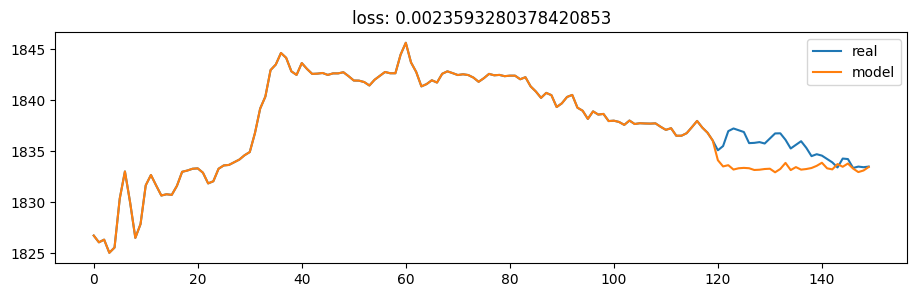

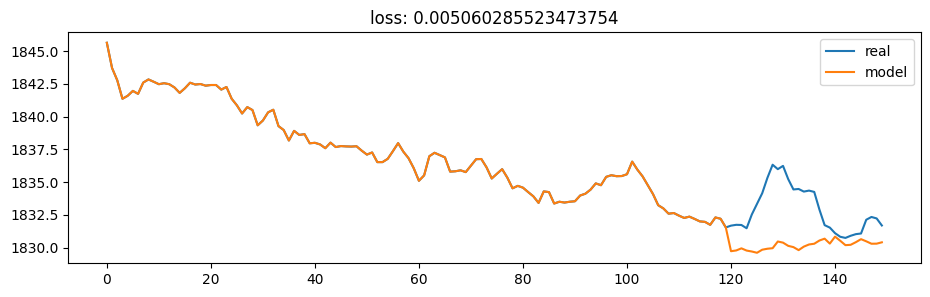

 17%|█▋        | 14/84 [00:01<00:06, 11.38it/s]

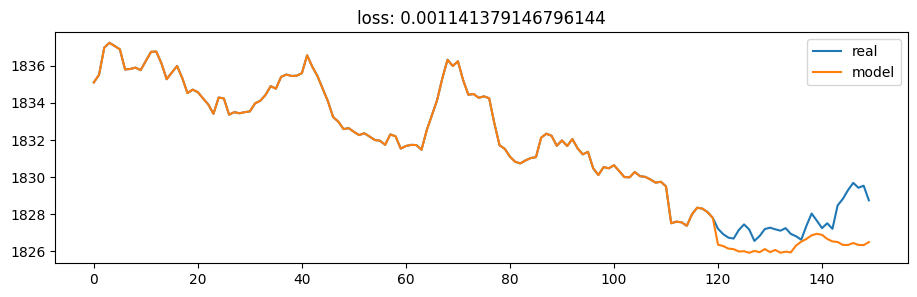

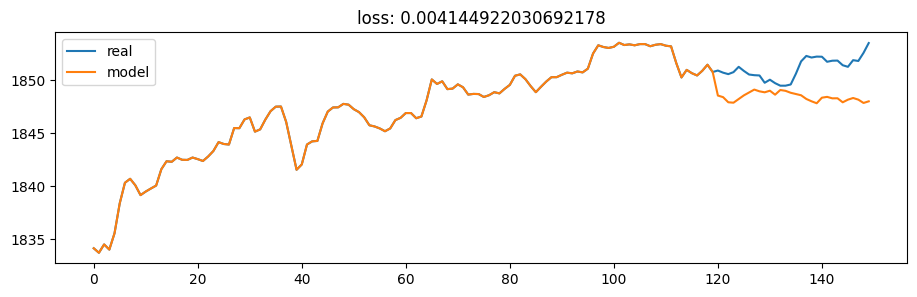

 19%|█▉        | 16/84 [00:01<00:05, 11.69it/s]

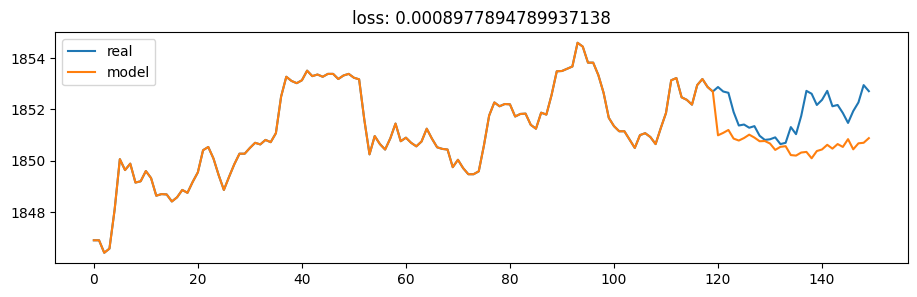

 20%|██        | 17/84 [00:01<00:05, 11.33it/s]


IndexError: list index out of range

In [45]:
vis = Visualize(args, mode='val', setting=setting, weights=sorted_weights[-1], title_meta=1, decision_log=0)
loss_list, preds, trues = [], [], []
for ts in tqdm(range(0, 5000, 60)):
    pred, true, loss = vis.plot(ts, plot=1, plt_len=None)
    preds.append(pred)
    trues.append(true)
    loss_list.append(loss)

## Visualize pertervations

Load model from /Users/shiva/Desktop/data_maestro//checkpoints/mod_nlinear_attention_sl120_pl30_ds_03_23_tg_0_ch_3_test/checkpoint_0.0033.pth
Original data shape: (14250, 4)
Data shape after inter-day:  8550
val 826


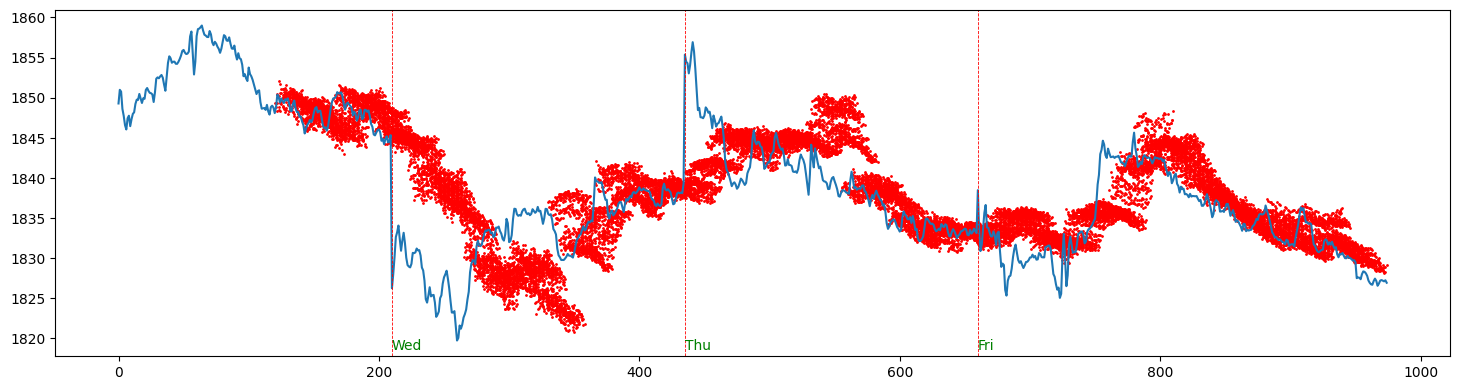

In [37]:
scatter = Scatter(args, setting, sorted_weights[-1], mode='val')
scatter.plot(segment=[0, 1000]) ; plt.show()

In [218]:
args = {
   'root_path': ltsf,
   'checkpoints': '{}/checkpoints/'.format(data_dir),
   'data_path': '03_23.csv',
   'seq_len': 120,
   'pred_len': 30,
   'batch_size': 16,
   'learning_rate': 0.05,
   'train_only': False,
   'train_epochs': 20,
   'data_segment': None,
   'model': 'nlinear_attention',
   'enc_in': 397,
   'patience': 5,
   'target': 0,
   'stocks': None
}

for key, value in args.items():
    default_args[key] = value
args = argparse.Namespace(**default_args)
setting = 'mod_{}_sl{}_pl{}_ds_{}_tg_{}_ch_{}'.format(args.model, args.seq_len, args.pred_len, args.data_path.split('.')[0], args.target, args.enc_in)
weights = os.listdir("{}/{}".format(args.checkpoints, setting))
sorted_weights = sorted(weights, key=lambda x: float(x.replace('checkpoint_','').replace('.pth','')), reverse=True)
model.load_state_dict(torch.load("{}/{}/{}".format(args.checkpoints, setting, sorted_weights[-1])))
attn_weights = model.Attention.weight.cpu().detach().numpy().copy()
sorted_weights[-1]

'checkpoint_0.0043.pth'

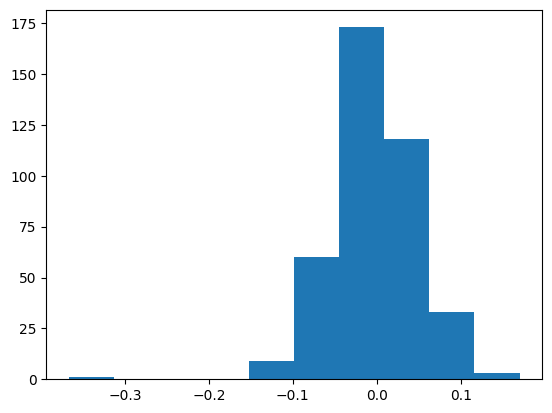

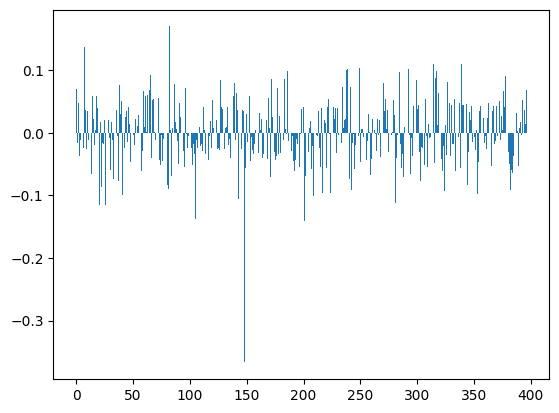

In [221]:
plt.hist(attn_weights[0]) ; plt.show()
plt.bar(np.arange(397), attn_weights[0]) ; plt.show()

In [162]:
stocks = [i for i in range(len(attn_weights[0])) if abs(attn_weights[0][i])>0.3]
sorted(stocks)

[148]

In [233]:
# sort attn_weights_test preserving index
a = np.array(abs(attn_weights_test[0])).argsort()[::-1]
a[:10]

array([138, 149, 159,  12, 357, 297, 152, 195,  98, 177])

In [234]:
# sort attn_weights_test preserving index
a = np.array(abs(attn_weights[0])).argsort()[::-1]
a[:10]

array([148,  82, 201, 105,   7, 203,  20,  26, 281, 314])

In [169]:
stocks = [i for i in range(len(attn_weights_test[0])) if abs(attn_weights_test[0][i])>0.15]
sorted(stocks)

[74, 206, 270]

In [208]:
attn_weights_test[0][:5], attn_weights[0][:5]

(array([ 0.06986644, -0.01674734,  0.04850215, -0.03687299, -0.01129768],
       dtype=float32),
 array([ 0.06986644, -0.01674734,  0.04850215, -0.03687299, -0.01129768],
       dtype=float32))

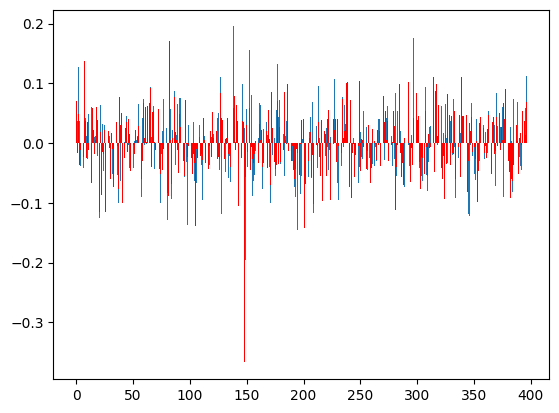

'checkpoint_0.2812.pth'

In [222]:
model.load_state_dict(torch.load("{}/{}/{}".format(args.checkpoints, setting, sorted_weights[0])))
attn_weights_test = model.Attention.weight.cpu().detach().numpy()
# plt.hist(attn_weights_test[0]) ; plt.show()
plt.bar(np.arange(397), attn_weights_test[0]) ;plt.bar(np.arange(397), attn_weights[0], color='red') ; plt.show()
sorted_weights[-3]

In [42]:
args = {
   'root_path': ltsf,
   'checkpoints': '{}/checkpoints/'.format(data_dir),
   'data_path': '03_23.csv',
   'seq_len': 120,
   'pred_len': 30,
   'batch_size': 16,
   'learning_rate': 0.05,
   'train_only': False,
   'train_epochs': 20,
   'data_segment': None,
   'model': 'nlinear_attention',
   'enc_in': 3,
   'patience': 5,
   'target': 0,
   'stocks': [4, 314, 142]
}

for key, value in args.items():
    default_args[key] = value
args = argparse.Namespace(**default_args)


print("\n-------------Training for target {}-------------\n".format(args.target))
exp = ExpMain(args)
setting = 'mod_{}_sl{}_pl{}_ds_{}_tg_{}_ch_{}_test'.format(args.model, args.seq_len, args.pred_len, args.data_path.split('.')[0], args.target, args.enc_in)
exp.train(setting)


-------------Training for target 0-------------

Use CPU
Total number of parameters is: 3634
Original data shape: (14250, 4)
Data shape after inter-day:  8550
train 5836
Original data shape: (14250, 4)
Data shape after inter-day:  8550
val 826


100%|██████████| 364/364 [00:58<00:00,  6.25it/s]


Epoch: 1 | time: 58.25293779373169


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch: 1, Steps: 364 | Train Loss: 0.0747253 Vali Loss: 0.0364049
Validation loss decreased (inf --> 0.036405).  Saving model ...
Updating learning rate to 0.05


100%|██████████| 364/364 [00:58<00:00,  6.25it/s]


Epoch: 2 | time: 58.24167609214783


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch: 2, Steps: 364 | Train Loss: 0.0525028 Vali Loss: 0.0805105
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.025


100%|██████████| 364/364 [00:57<00:00,  6.30it/s]


Epoch: 3 | time: 57.81903791427612


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch: 3, Steps: 364 | Train Loss: 0.0244321 Vali Loss: 0.0243121
Validation loss decreased (0.036405 --> 0.024312).  Saving model ...
Updating learning rate to 0.0125


100%|██████████| 364/364 [00:57<00:00,  6.30it/s]


Epoch: 4 | time: 57.800328969955444


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch: 4, Steps: 364 | Train Loss: 0.0172102 Vali Loss: 0.0154384
Validation loss decreased (0.024312 --> 0.015438).  Saving model ...
Updating learning rate to 0.00625


100%|██████████| 364/364 [00:57<00:00,  6.32it/s]


Epoch: 5 | time: 57.62936615943909


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch: 5, Steps: 364 | Train Loss: 0.0145782 Vali Loss: 0.0142694
Validation loss decreased (0.015438 --> 0.014269).  Saving model ...
Updating learning rate to 0.003125


100%|██████████| 364/364 [00:57<00:00,  6.31it/s]


Epoch: 6 | time: 57.718677043914795


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch: 6, Steps: 364 | Train Loss: 0.0141229 Vali Loss: 0.0125867
Validation loss decreased (0.014269 --> 0.012587).  Saving model ...
Updating learning rate to 0.0015625


100%|██████████| 364/364 [00:57<00:00,  6.29it/s]


Epoch: 7 | time: 57.87627291679382


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch: 7, Steps: 364 | Train Loss: 0.0135269 Vali Loss: 0.0118882
Validation loss decreased (0.012587 --> 0.011888).  Saving model ...
Updating learning rate to 0.00078125


100%|██████████| 364/364 [00:26<00:00, 13.78it/s]


KeyboardInterrupt: 

In [9]:
from models.nlinear_attention import Model

args = {
   'root_path': ltsf,
   'checkpoints': '{}/checkpoints/'.format(data_dir),
   'data_path': '03_23.csv',
   'seq_len': 120,
   'pred_len': 30,
   'batch_size': 16,
   'learning_rate': 0.05,
   'train_only': False,
   'train_epochs': 20,
   'data_segment': None,
   'model': 'nlinear_attention',
   'enc_in': 397,
   'patience': 5,
   'target': 0,
   'stocks': None
}

for key, value in args.items():
    default_args[key] = value
args = argparse.Namespace(**default_args)

class Config:
    def __init__(self):
        self.seq_len = 120
        self.pred_len = 30
        self.enc_in = 397
        self.individual = False
        self.decomp_kernal = 25
model = Model(Config())


In [10]:
stock_heatmap_matrix = get_stock_heatmap_matrix(model, 99, args)
stock_heatmap_matrix_2 = get_stock_heatmap_matrix(model, 99, args, setting_suffix='_2')

In [11]:
a = get_stock_meta("{}/instruments.json".format(ltsf), "{}/03_23.csv".format(ltsf))
names = []
for k, v in a.items():
    names.append(v['name'])

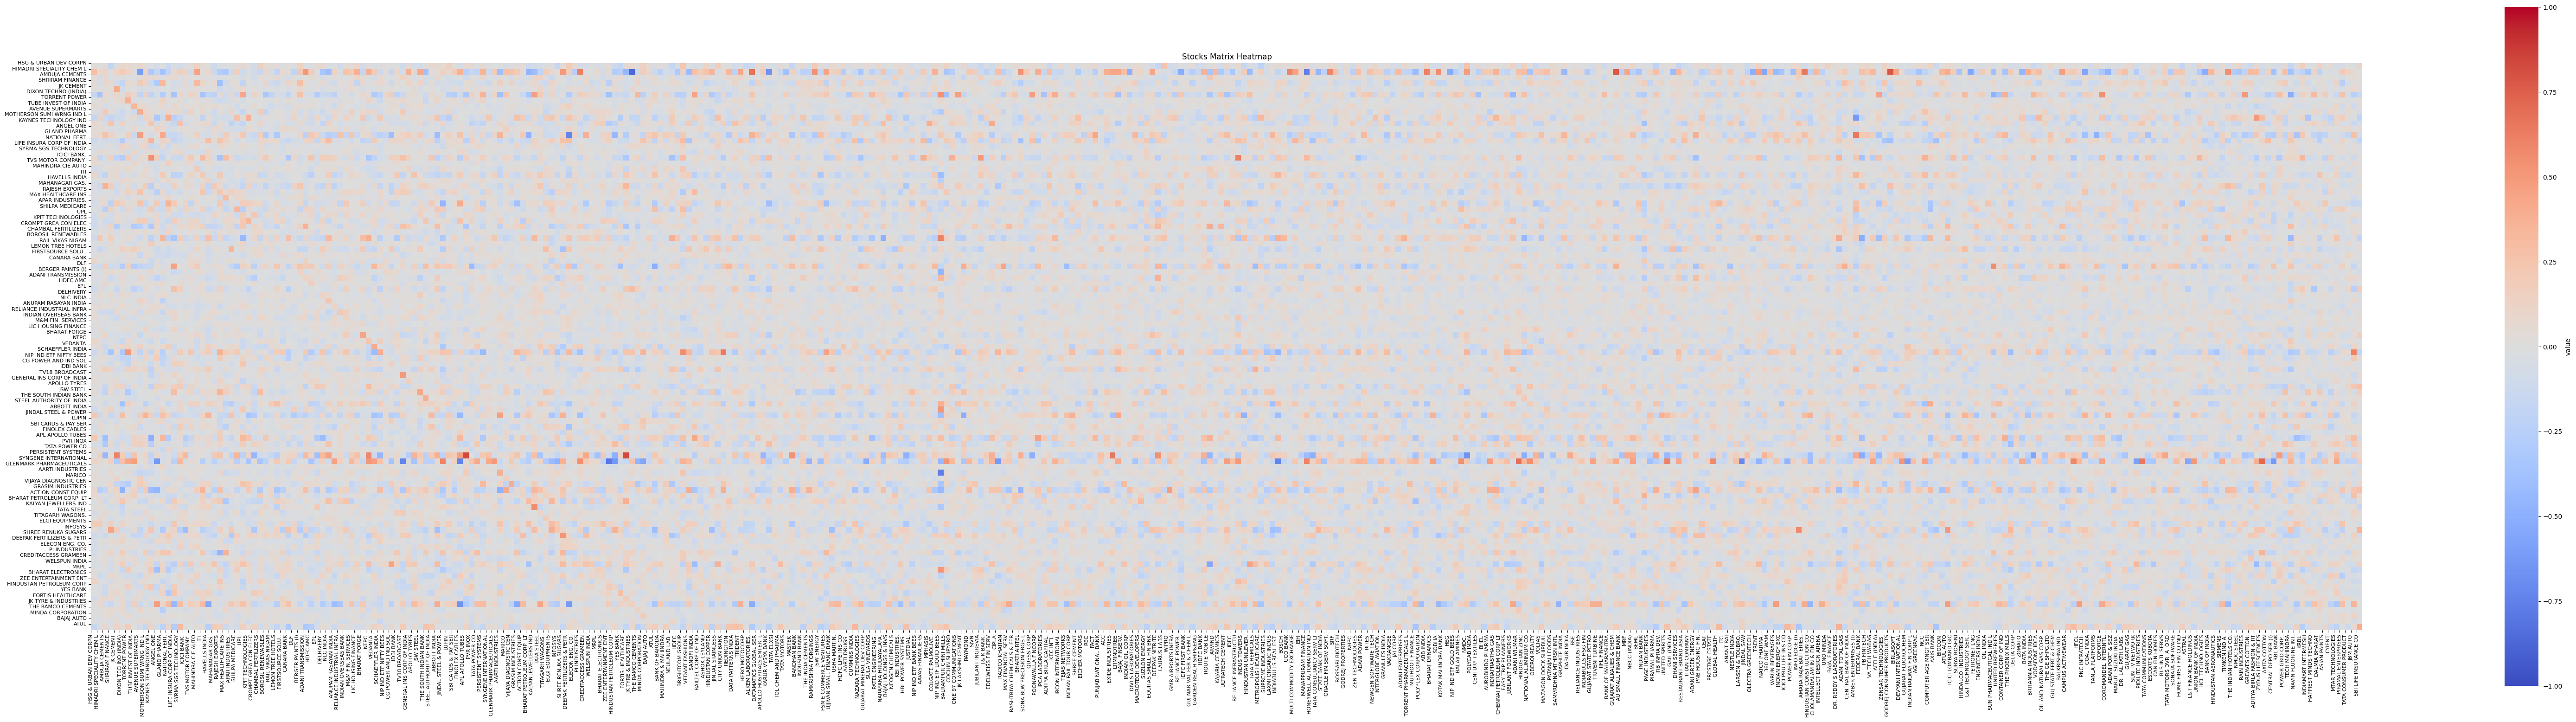

In [12]:
craete_heatmap(stock_heatmap_matrix, names)

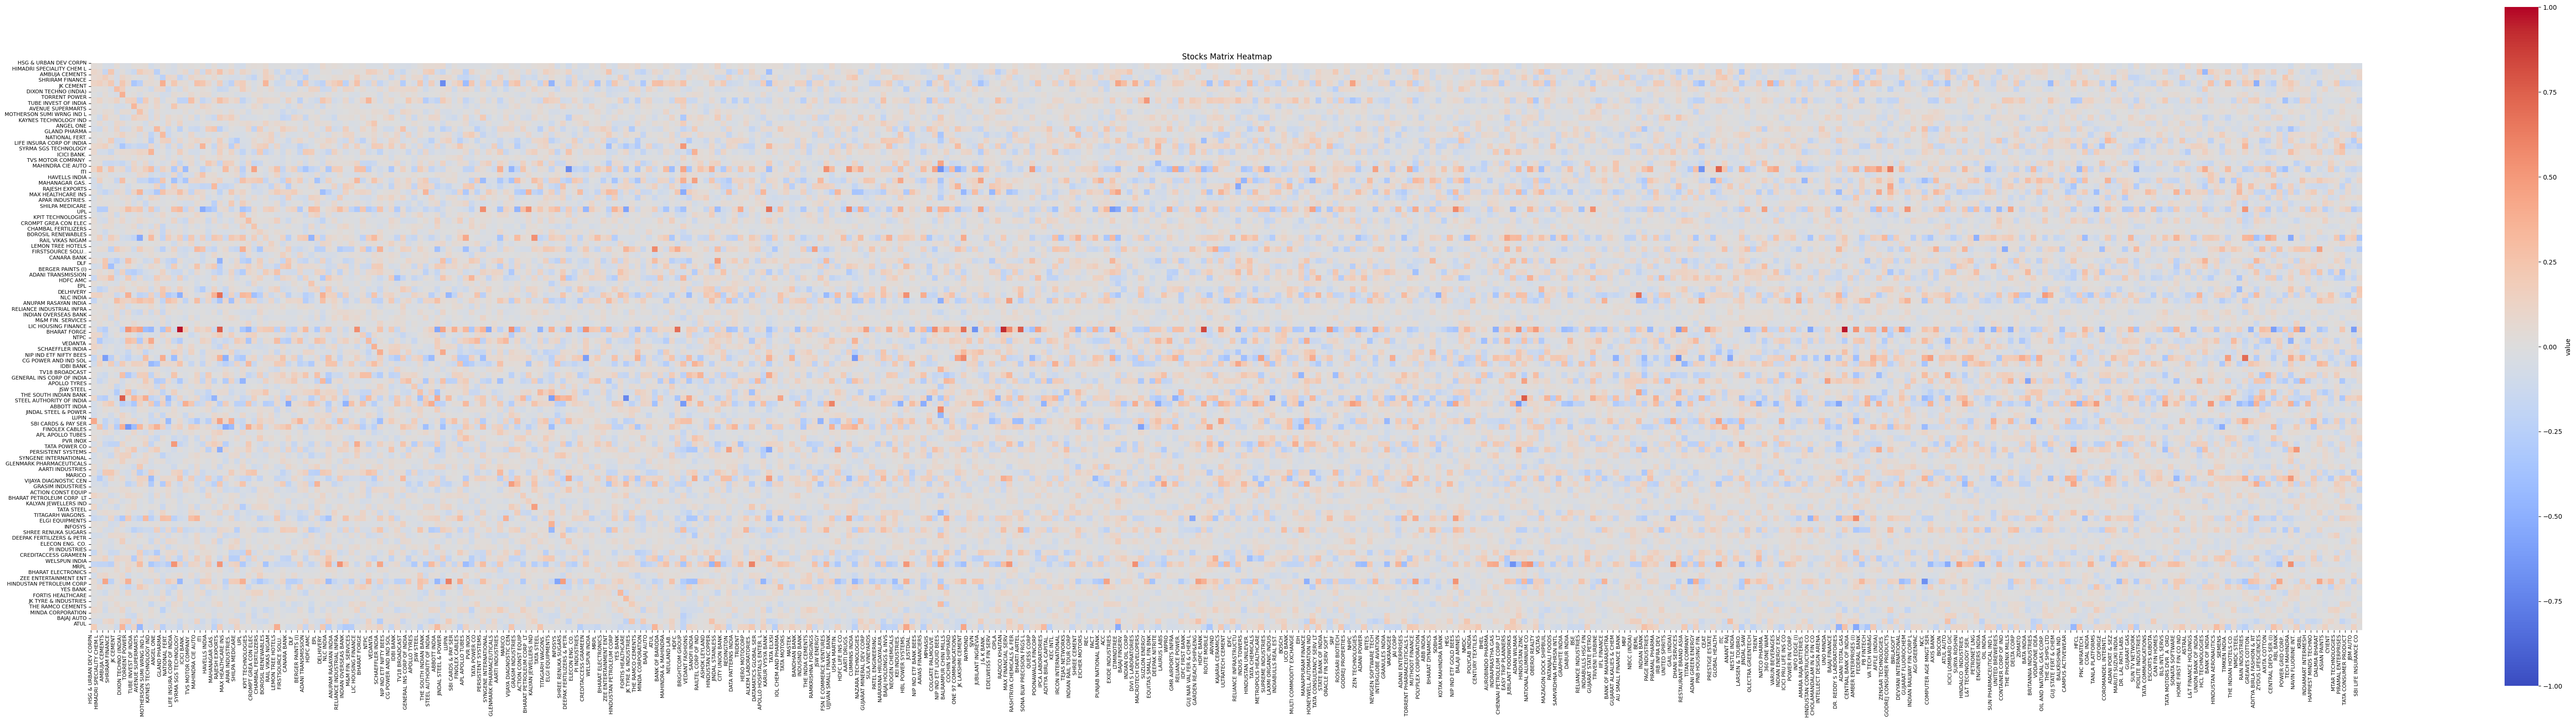

In [13]:
craete_heatmap(stock_heatmap_matrix_2, names)

In [14]:
# args sort each stock in axis0 by taking abs first
a = np.argsort(abs(stock_heatmap_matrix), axis=1)[:, ::-1]
b = np.argsort(abs(stock_heatmap_matrix_2), axis=1)[:, ::-1]
a.shape, b.shape

((99, 397), (99, 397))

In [40]:
k = 6
common_stock_map = {}
for i in range(99):
    common = set(a[i][:k]).intersection(set(b[i][:k]))
    common_stock_map[i] = common

In [41]:
l = []
# sort the common_stock_map by length of common stocks
sorted_map = sorted(common_stock_map.items(), key=lambda x: len(x[1]), reverse=True)
for i in sorted_map:
    l.append(len(i[1]))
    print(i[0], names[i[0]], len(i[1]), i[1])

4 JK CEMENT 3 {314, 4, 142}
38 HDFC AMC 3 {321, 179, 38}
23 MAX HEALTHCARE INS 2 {355, 95}
47 BHARAT FORGE 2 {314, 118}
64 FINOLEX CABLES 2 {64, 22}
72 MARICO 2 {384, 118}
92 YES BANK 2 {92, 13}
1 HIMADRI SPECIALITY CHEM L 1 {118}
5 DIXON TECHNO (INDIA) 1 {376}
7 TUBE INVEST OF INDIA 1 {7}
8 AVENUE SUPERMARTS 1 {8}
10 KAYNES TECHNOLOGY IND 1 {138}
11 ANGEL ONE 1 {11}
14 LIFE INSURA CORP OF INDIA 1 {103}
15 SYRMA SGS TECHNOLOGY 1 {105}
18 MAHINDRA CIE AUTO 1 {83}
21 MAHANAGAR GAS. 1 {314}
22 RAJESH EXPORTS 1 {103}
27 KPIT TECHNOLOGIES 1 {27}
28 CROMPT GREA CON ELEC 1 {324}
30 BOROSIL RENEWABLES 1 {384}
35 DLF 1 {332}
41 NLC INDIA 1 {148}
44 INDIAN OVERSEAS BANK 1 {103}
46 LIC HOUSING FINANCE 1 {162}
48 NTPC 1 {384}
49 VEDANTA 1 {49}
53 IDBI BANK 1 {384}
55 GENERAL INS CORP OF INDIA 1 {26}
58 THE SOUTH INDIAN BANK 1 {250}
60 ABBOTT INDIA 1 {148}
63 SBI CARDS & PAY SER 1 {23}
65 APL APOLLO TUBES 1 {105}
67 TATA POWER CO 1 {118}
71 AARTI INDUSTRIES 1 {71}
73 VIJAYA DIAGNOSTIC CEN 1 {73}
76